# Predicting car prices

This project aims to predict a car's market price using its attributes. The [dataset](https://archive.ics.uci.edu/ml/datasets/automobile) used contains information on various cars about their technical aspects (weight, the miles per gallon, how fast it accelerates, etc.).

## Data overview and cleaning

In [1]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Read the dataset
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg',
        'price']

cars = pd.read_csv('imports-85.data', names=cols)
cars

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [4]:
# Replace all "?" characters with the nan
cars.replace('?', np.nan, inplace=True)

# Select the numeric columns
cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke',
        'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = cars[cols]

# Convert all columns to numeric type
cars = cars.astype('float')
cars.isnull().sum() / cars.shape[0] * 100

normalized-losses    20.00000
wheel-base            0.00000
length                0.00000
width                 0.00000
height                0.00000
curb-weight           0.00000
engine-size           0.00000
bore                  1.95122
stroke                1.95122
compression-rate      0.00000
horsepower            0.97561
peak-rpm              0.97561
city-mpg              0.00000
highway-mpg           0.00000
price                 1.95122
dtype: float64

The column ` normalized-losses` has 20% of missing values, which is very significant. Let’s look at the correlation between this column and the target column `price`.

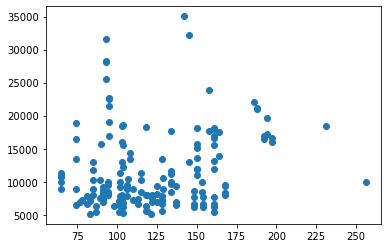

In [5]:
plt.scatter(cars["normalized-losses"], cars["price"])

The correlation is not significant, and so this column will be removed.

In [6]:
cars.drop("normalized-losses", axis=1, inplace=True)

The other missing values are not significant and will be replaced using the average values from the respective columns.

In [7]:
cars.fillna(cars.mean(), inplace=True)

We will now normalize all of the columns to have a mean of 0 and a standard deviation of 1.

In [8]:
price = cars["price"]

cars = (cars - cars.mean()) / (cars.std())

cars["price"] = price

## Univariate model

Let's start with some univariate k-nearest neighbors models. Starting with simple models before moving to more complex models helps us structure your code workflow and understand the features better.

In [9]:
def validate_univariate_model(df, feature, target, k):

    # Randomize the order of rows of the DataFrame
    df_r = df.copy().sample(frac=1, random_state=1)

    # Divide into training and test sets using a 4:1 proportion
    k_row = int(df_r.shape[0] * 0.8)
    train_set = df_r.iloc[:k_row]
    test_set = df_r.iloc[k_row:]

    # Instantiate regression model based on k-nearest neighbors
    model = KNeighborsRegressor(n_neighbors=k)

    # Fit the model using the training data and target values
    model.fit(train_set[[feature]], train_set[target])

    # Predict the target for the test data
    predictions = model.predict(test_set[[feature]])

    # Return the root mean squared error
    return np.sqrt(mean_squared_error(test_set[target], predictions))

To decide which feature to use, we will see how the different features are correlated with the price.

In [10]:
features_corr = cars.corr()["price"].abs().sort_values(ascending=False)[1:]
features_corr

engine-size         0.861752
curb-weight         0.820825
horsepower          0.757917
width               0.728699
highway-mpg         0.690526
length              0.682986
city-mpg            0.667449
wheel-base          0.583168
bore                0.532300
height              0.134388
peak-rpm            0.100854
stroke              0.082095
compression-rate    0.070990
Name: price, dtype: float64

In [11]:
rmses = [validate_univariate_model(cars, feature, "price", 5) for feature in features_corr.index]
rmses = pd.Series(rmses, index=features_corr.index)
rmses

engine-size         4786.132749
curb-weight         4319.695406
horsepower          5866.955744
width               5641.273776
highway-mpg         4568.396590
length              4982.958124
city-mpg            4758.353651
wheel-base          6062.271692
bore                7210.042582
height              7854.034877
peak-rpm            8346.789073
stroke              7109.791200
compression-rate    7744.827759
dtype: float64

Text(0, 0.5, 'Root mean squared error')

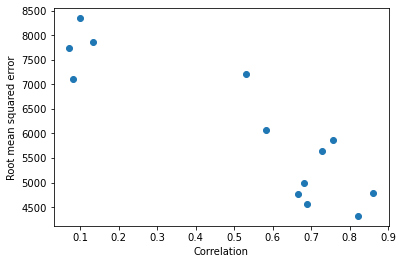

In [12]:
plt.scatter(features_corr, rmses)
plt.xlabel("Correlation")
plt.ylabel("Root mean squared error")

We can see that, overall, the more correlated a feature is with the price, the lower is the root mean squared error. Let’s now look at how the number of neighbours (k) the model uses affects the results. This time we will use the feature ` curb-weight`, which led to the most accurate model.

k = 11 led to the minimum error.


Text(0, 0.5, 'Root mean squared error')

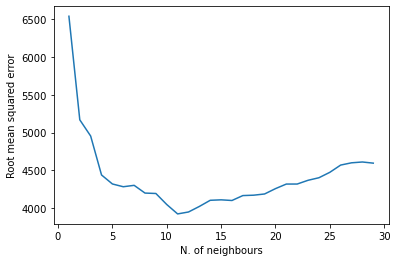

In [13]:
ks = range(1,30)

rmses = [validate_univariate_model(cars, "curb-weight", "price", k) for k in ks]

plt.plot(ks, rmses)

print("k = {} led to the minimum error.".format(np.argmin(rmses) + 1))
plt.xlabel("N. of neighbours")
plt.ylabel("Root mean squared error")

Using 11 neighbours led to the lowest error.

## Multivariate model

Let's modify the knn_train_test() function we wrote in the last step to work with multiple columns.

In [14]:
def validate_multivariate_model(df, features, target, k):

    # Randomize the order of rows of the DataFrame
    df_r = df.copy().sample(frac=1, random_state=1)

    # Divide into training and test sets using a 4:1 proportion
    k_row = int(df_r.shape[0] * 0.8)
    train_set = df_r.iloc[:k_row].reset_index(drop=True)
    test_set = df_r.iloc[k_row:].reset_index(drop=True)

    # Instantiate regression model based on k-nearest neighbors
    model = KNeighborsRegressor(n_neighbors=k)

    # Fit the model using the training data and target values
    model.fit(train_set[features], train_set[target])

    # Predict the target for the test data
    predictions = model.predict(test_set[features])

    # Return the root mean squared error
    return np.sqrt(mean_squared_error(test_set[target], predictions))

To study how the number of features influences the accuracy of the model. We will gradually increase the number used from two to all. We will use k = 5 for now.

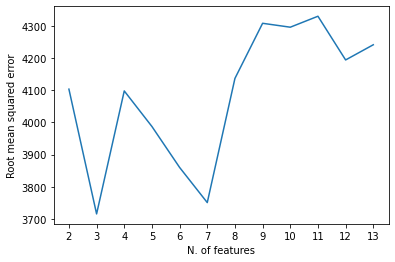

In [15]:
n_features = range(2,len(features_corr) + 1)

rmses = [validate_multivariate_model(cars, features_corr.index[:n], "price", 5) for n in n_features]

plt.plot(n_features, rmses)
plt.xlabel("N. of features")
plt.ylabel("Root mean squared error")
plt.xticks(range(2,14));

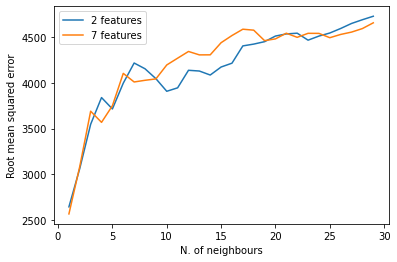

In [16]:
ks = range(1,30)

rmses = [validate_multivariate_model(cars, features_corr.index[:3], "price", k) for k in ks]

plt.plot(ks, rmses, label="2 features")

rmses = [validate_multivariate_model(cars, features_corr.index[:7], "price", k) for k in ks]

plt.plot(ks, rmses, label="7 features")

plt.xlabel("N. of neighbours")
plt.ylabel("Root mean squared error")
plt.legend()

The models using the two and seven best features have similar accuracy. Also, the models using only one neighbour had the best accuracy.

## Conclusions

The best model is the one that uses the features `engine-size` and ` curb-weight`, and one neighbour.